In [1]:
from skimage.io import imread
import pyclesperanto_prototype as cle
from skimage.measure import regionprops_table
import numpy as np
import pandas as pd
from scipy.ndimage import zoom

In [2]:
image_stack = imread("../../data/CalibZAPWfixed_000154_max.tif")[::10,:200,:200]
image_stack = np.asarray(cle.scale(image_stack, factor_z=1, factor_x=6, factor_y=6, auto_size=True))
image_stack.shape

(10, 1200, 1200)

In [3]:
def segment_single_image(image, bg_radius=50, spot_sigma=10, outline_sigma=3):
    background_subtracted = cle.top_hat_box(image, radius_x=bg_radius, radius_y=bg_radius)
    labels = cle.voronoi_otsu_labeling(background_subtracted, spot_sigma=spot_sigma, outline_sigma=outline_sigma)
    return np.asarray(labels)

In [4]:
segment_single_image(image_stack[5])

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 177, 177, 177],
       [  0,   0,   0, ..., 177, 177, 177],
       [  0,   0,   0, ..., 177, 177, 177]], dtype=uint32)

In [10]:
segmented_slices = [segment_single_image(image) for image in image_stack]
segmented_stack = np.asarray(segmented_slices)
segmented_stack.shape

(10, 1200, 1200)

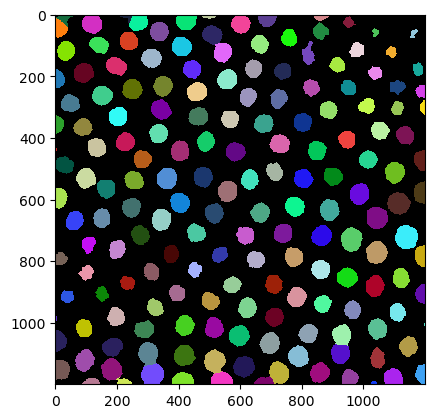

In [13]:
cle.imshow(segmented_slices[5], labels=True)

In [7]:
import stackview
stackview.curtain(image_stack, segmented_stack, zoom_factor=0.3)

In [21]:
def analyze_single_timepoint(image, labels, frame):
    df = pd.DataFrame(regionprops_table(labels[frame], intensity_image=image[frame], properties=['mean_intensity']))
    df['frame'] = frame
    return df

df = analyze_single_timepoint(image_stack, segmented_stack, 5)

In [22]:
num_frames = image_stack.shape[0]
all_frames_df = pd.concat([analyze_single_timepoint(image_stack, segmented_stack, t) for t in range(num_frames)])

all_frames_df

,mean_intensity,frame
0,223.347107,0
1,93.042557,0
2,112.046814,0
3,192.766434,0
4,162.704330,0
...,...,...
335,135.748642,9
336,116.306427,9
337,121.075317,9
338,98.173592,9


In [23]:
import timeit

In [24]:
%%timeit
pd.concat([analyze_single_timepoint(image_stack, segmented_stack, t) for t in range(num_frames)])

87 ms ± 649 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [36]:
def get_intensity_for_timepoint(intensity_image, label_layer):
    stats = regionprops_table(label_layer, intensity_image=intensity_image, properties=['mean_intensity'])
    return stats['mean_intensity']

def get_intensity(intensity_image_stack, labels_layer_stack):
    result = []        
    for intensity_image, label_layer in zip(intensity_image_stack, labels_layer_stack):
        result.append(get_intensity_for_timepoint(intensity_image, label_layer))
    return result


In [38]:
.shape

(10, 1, 1200, 1200)

In [42]:

from napari_skimage_regionprops import regionprops_table_all_frames
stats = regionprops_table_all_frames(image_stack[:,np.newaxis,:,:], 
                             segmented_stack[:,np.newaxis,:,:],
                             size=False,
                             intensity=True)
pd.DataFrame(stats)

analyzing frame 0
analyzing frame 1
analyzing frame 2
analyzing frame 3
analyzing frame 4
analyzing frame 5
analyzing frame 6
analyzing frame 7
analyzing frame 8
analyzing frame 9


,label,max_intensity,mean_intensity,min_intensity,standard_deviation_intensity,frame
0,1,255.0,223.347107,91.0,40.516113,0
1,2,97.0,93.042557,70.0,7.657447,0
2,3,154.0,112.046814,68.0,16.508696,0
3,4,245.0,192.766434,85.0,39.013126,0
4,5,255.0,162.704330,67.0,42.194302,0
...,...,...,...,...,...,...
1697,336,189.0,135.748642,61.0,30.539036,9
1698,337,173.0,116.306427,38.0,35.460144,9
1699,338,183.0,121.075317,39.0,38.362331,9
1700,339,133.0,98.173592,55.0,22.237257,9
